
## GeostatsPy: Monte Carlo Simulation for Subsurface Data Analytics in Python 


### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### PGE 383 Exercise: Monte Carlo Simulation for Subsurface Data Analytics in Python 

Here's a simple workflow, demonstration of Monte Carlo simulation for subsurface uncertainty modeling workflows. This should help you get started with building subsurface models that integrate uncertainty sources.  

#### Monte Carlo Simulation

Definition: random sampling from a distribution

Procedure: 

1. Model the representative distribution (CDF)
2. Draw a random value from a uniform [0,1] distribution (p-value)
3. Apply the inverse of the CDF to calculate the associated realization

In practice, Monte Carlo simulation refers to the workflow with multiple realizations drawn to buld an uncertainty model. 

\begin{equation}
X^\ell = F_x(p^\ell),  \, \forall \, \ell = 1,\ldots, L
\end{equation}

where $X^\ell$ is the realization of the variable $X$ drawn from its CDF, $F_x$, with cumulative probability, p-value, $p^\ell$.  

It would be trivial to apply Monte Carlo simulation to a single variable, after many realizations one would get back the original distribution. The general approach is to:

1. Model all distributions for the input, variables of interest $F_{x_1},\ldots,F_{x_m}$.
2. For each realization draw $p^\ell_{1},\ldots,p^\ell_{m}$, p-values
3. Apply the inverse of each distribution to calculate a realization of each variable, $X^\ell_j = F_{x^\ell_j}^{-1}(p^\ell_j),  \, \forall \, j = 1,\ldots$, $m$ variables.
4. Apply each set of variables for a $\ell$ realization to the transfer function to calculate the ouptput realization, $Y^\ell = F(X_1^\ell,\ldots,X_m^\ell)$.

Monte Carlo Simulation (MCS) is extremely powerful

* Possible to easily simulate uncertainty models for complicated systems 
* Simulations are conducted by drawing values at random from specified uncertainty distributions for each variable
* A single realization of each variable, $X_1^\ell, X_2^\ell,\ldots,X_m^\ell$ is applied to the transfer function to calculate the realization of the variable of interest (output, decision criteria):

\begin{equation}
Y^\ell = F(X_1^\ell,\ldots,X_m^\ell), \, \forall \, \ell = 1,\ldots, L
\end{equation}

* The MCS method builds empirical uncertainty models by random sampling

Let’s take a simple example, $OIP$ is oil-in-place calculated as the product of reservoir volume, $V$, average porosity, $\overline{\phi}$, and oil saturaton, $\overline{s_o}$:

\begin{equation}
OIP^\ell = V^\ell \cdot \overline{\phi}^\ell \cdot \overline{s_o}^\ell, \, \forall \, \ell = 1,\ldots, L
\end{equation}

It would be difficult to directly calculate the OIP distribution as a combination of all these different distributions. 
* The distributions could all have different forms (parametric or non-parametric)
* We use MCS to empirically work this out by sampling
* Repeat to calculate enough realizations for analysis.

How many realizations, $L$?

The answer is enough! If the MCS computational cost is low then **many** is the right answer. If too few realizations are calculated then the summary statistics and the entire CDF of the output, decision criteria may be incorrect. This is caused by fluctuations due to not enough samples (see the 'Law of Small Numbers').

The MCS method is very powerful. You can simulate output distributions that could not be calculated analytically.  

#### Limitations

The MCS method above assumes:
1. **representativity** - the distribution is representative
2. **independence** - the variables are independent of eachother
3. **stationarity** - all realizations for each variable are from the same distribution 

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

There are examples below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [84]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [85]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import random

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [89]:
os.chdir("c:/PGE383")                     # set the working directory

#### Simple Monte Carlo Simulation Example

Let's work out the OIP uncertainty example above. Let's work with parametric distributions for average porosity, $apor$, volume, $vol$ and oil saturation, $so$. Here's some parameters for these distributions. Note, these parameters could originate from a bootstrap workflow, analogs, etc. 

In [90]:
apor_mean = 0.15; apor_stdev = 0.02       # Gaussian mean and standard deviation porosity (fraction)
vol_mu = 13.0; vol_sigma = 0.5            # LogNormal mu and sigma volume (m^3)
so_min = 0.2; so_max = 0.4                # Uniform minimum and maximum oil saturation (fraction)
L = 1000                                  # Number of MCS realizations

Let's set the minimum and maximum values for plotting.

In [91]:
apor_min = 0.1; apor_max = 0.2            # average porosity min and max
vol_min = 0.0; vol_max = 4000000          # vol min and max

In the *NumPy* package we have handy methods for Monte Carlo simulation from parametric distributions. We can actually draw all $L$ realizations at once for each variable and store them in ndarrays (each ndarray with realizations $\ell = 1,\ldots,L$).  

In [92]:
apor = np.random.normal(apor_mean, apor_stdev, size=L) # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)   # volume ...
so = np.random.uniform(so_min, so_max, size=L)         # saturation oil

Let's plot the distributions of the realizations of each variable to make sure the match the form of the parametric distributions that we selected.

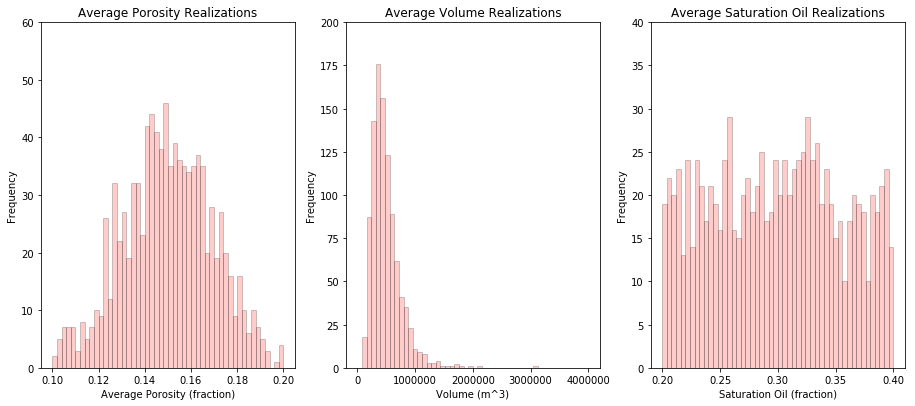

In [93]:
plt.subplot(131)
GSLIB.hist_st(apor,apor_min,apor_max,log=False,cumul=False,bins=50,weights=None,xlabel="Average Porosity (fraction)",title="Average Porosity Realizations")
plt.ylim(0.0,60)

plt.subplot(132)
GSLIB.hist_st(vol,vol_min,vol_max,log=False,cumul=False,bins=50,weights=None,xlabel="Volume (m^3)",title="Average Volume Realizations")
plt.ylim(0.0,200)

plt.subplot(133)
GSLIB.hist_st(so,so_min,so_max,log=False,cumul=False,bins=50,weights=None,xlabel="Saturation Oil (fraction)",title="Average Saturation Oil Realizations")
plt.ylim(0.0,40)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

This looks good, the shapes are Gaussian, lognormal and uniform and the central tendency and dispersion make sense given the parameters that we selected.

Now we can use broadcast methods to calculate the output realizations of $OIP$, based on this equation.

\begin{equation}
OIP^\ell = V^\ell \cdot \overline{\phi}^\ell \cdot \overline{s_o}^\ell \cdot 6.29 \quad \forall \, \ell = 1,\ldots, L
\end{equation}

where 6.26 $bbls/m^3$.

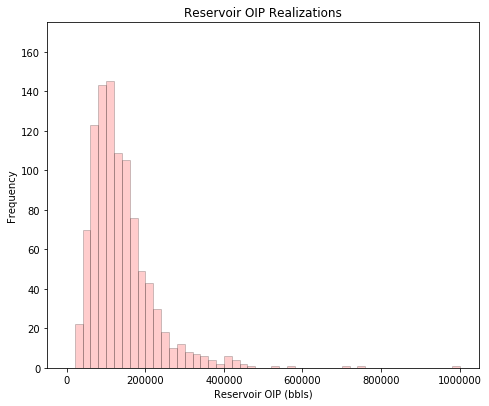

In [94]:
OIP = apor * vol * so * 6.29

plt.subplot(111)
GSLIB.hist_st(OIP,0.0,1000000,log=False,cumul=False,bins=50,weights=None,xlabel="Reservoir OIP (bbls)",title="Reservoir OIP Realizations")
plt.ylim(0.0,175)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

It's not a bad idea to check your calculation. Let's compare the first and last realizations of $OIP$ to the results from performing the calculation by hand. 

In [69]:
print('Check realization 0, broadcast method = ' + str(round(OIP[0],3)) + ' compare to by-hand ' + str(round(apor[0]*vol[0]*so[0]*6.29,3)))
print('Check realization L-1, broadcast method = ' + str(round(OIP[L-1],3)) + ' compare to by-hand ' + str(round(apor[L-1]*vol[L-1]*so[L-1]*6.29,3)))

Check realization 0, broadcast method = 117394.232 compare to by-hand 117394.232
Check realization L-1, broadcast method = 90446.182 compare to by-hand 90446.182


The results check out.  

Now let's look at what happens if too few realizations are used!  Set the $L$ smaller, calculate 3 sets of $L$ realizations.

In [95]:
L = 100                                                # set L small 
# First set of realizations
apor = np.random.normal(apor_mean, apor_stdev, size=L) # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)   # volume ...
so = np.random.uniform(so_min, so_max, size=L)         # saturation oil
OIP1 = apor * vol * so * 6.29                          # calculate OIP

# Second set of realizations
apor = np.random.normal(apor_mean, apor_stdev, size=L) # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)   # volume ...
so = np.random.uniform(so_min, so_max, size=L)         # saturation oil
OIP2 = apor * vol * so * 6.29                          # calculate OIP

# Third set of realizations
apor = np.random.normal(apor_mean, apor_stdev, size=L) # average porosity MCS simulation L times and store in array 
vol = np.random.lognormal(vol_mu, vol_sigma, size=L)   # volume ...
so = np.random.uniform(so_min, so_max, size=L)         # saturation oil
OIP3 = apor * vol * so * 6.29                          # calculate OIP

Let's look at the distributions, and calculate and compare the average for each of the 3 sets.

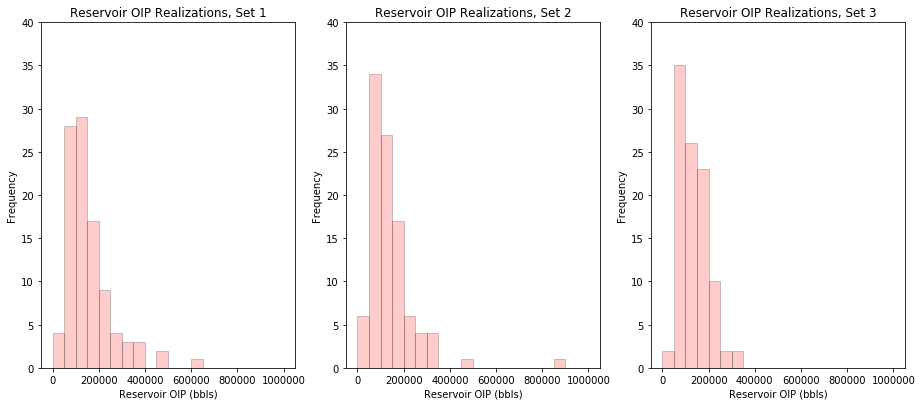

The average OIP for large number of realizations = 138352.546
The average OIP for small number of realizations = 156296.224, 141280.388,134355.572


In [96]:
plt.subplot(131)
GSLIB.hist_st(OIP1,0.0,1000000,log=False,cumul=False,bins=20,weights=None,xlabel="Reservoir OIP (bbls)",title="Reservoir OIP Realizations, Set 1")
plt.ylim(0.0,40)

plt.subplot(132)
GSLIB.hist_st(OIP2,0.0,1000000,log=False,cumul=False,bins=20,weights=None,xlabel="Reservoir OIP (bbls)",title="Reservoir OIP Realizations, Set 2")
plt.ylim(0.0,40)

plt.subplot(133)
GSLIB.hist_st(OIP3,0.0,1000000,log=False,cumul=False,bins=20,weights=None,xlabel="Reservoir OIP (bbls)",title="Reservoir OIP Realizations, Set 3")
plt.ylim(0.0,40)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print('The average OIP for large number of realizations = ' + str(round(np.average(OIP),3)))
print('The average OIP for small number of realizations = ' + str(round(np.average(OIP1),3)) + ', ' + str(round(np.average(OIP2),3)) + ',' + str(round(np.average(OIP3),3)))

Try setting the number of realizations, $L$, larger and you will see that the 3 sets of realizations converge, they become stable. This is why we set $L$ large. 

#### Non-Parametric Monte Carlos Simulation

I have demonstrated the case of MCS with parametric distributions. Of course, we may have non-parametric distributions. In this case we are working with a list of values (typically in an 1D ndarray). For this case we simply substitute in the command:

```p
apor = np.random.choice(array_average_porosity,size=L)
```

The result is a ndarray with $L$ Monte Carlo simulations from the array 'array_average_porosity'.  This is simply $L$ random draws with replacement (so the same value may be selected again), from the list of values in the ndarray.

#### Comments

This was a basic demonstration of Monte Carlo simulation for uncertainty analysis. A lot more could be done, for example, more complicated transfer functions and a combination of non-parametric and parametric distributions. Also, one could integrate relationships between the variables (we assumed independent here).

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling, multivariate analysis and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
